# 设置参数
配置的参数,需要与采集数据时雷达配置的参数一致

In [1]:
import torch
import os
import numpy as np
import glob
import numpy as np
import matplotlib.pyplot as plt
from RealTimeCollector.RealTimeCollector import RealTimeCollector
import scipy.io as sio
import queue

n_frames = 30   # 每个样本的帧数

rtc = RealTimeCollector(ip_address=f'127.0.0.4')

n_RX = 4  # RX天线通道总数
n_samples = 64  # 采样点数
n_chirps = 255  # 每帧脉冲数
N = 64  # 距离向FFT点数
M = 64  # 多普勒向FFT点数
Q = 64  # 角度FFT

c = 3.0e8   # 光速
B = 3999.48e6  # 调频带宽
K = 99.987e12  # 调频斜率
T = B / K  # 调频周期
Tc = 140e-6  # chirp总周期
fs = 2.5e6  # 采样率
f0 = 77e9  # 初始频率
lambda_val = c / f0  # 雷达信号波长
d = lambda_val / 2  # 天线阵列间距

numADCBits = 16 # ADC位数
numLanes = 4    # 通道数
isReal = 0      # 是否为实数

# 是否静态杂波滤除
is_static_clutter_removal = 1

distance_axis = torch.arange(0, N) * fs * c / (2 * K * N)   # 距离轴
velocity_axis = torch.arange(-M/2, M/2) * lambda_val / Tc / M / 2   # 速度轴



# 特征提取
需要修改的参数有：
- `num_classes`：分类的类别数
- `directory_path`：数据集的路径
## 数据集要求
- 数据集的文件夹名为类别的标签

```shell
|-- 1
|   |-- 1.bin
|   |-- 2.bin
|   |-- ...
|-- 2
|   |-- 1.bin
|   |-- 2.bin
|   |-- ...
|-- ...
```

In [7]:
import time

filename = 'K:/dataset/AA/1/1.bin'
# 读取文件
with open(filename, 'rb') as file:
    adcData = np.fromfile(file, dtype=np.int16)

# 实部虚部结合
adcData = adcData.reshape(numLanes*2, -1,order='F')
adcData = adcData[[0,1,2,3],:] + 1j*adcData[[4,5,6,7],:]

data_radar = np.reshape(adcData, (n_RX, n_samples, n_chirps, n_frames), order='F')

print(data_radar.shape)  # (4, 64, 255, 30)


# 计算时间
start = time.time()
for i in range(10):
    range_profile, speed_profile, angle_profile = rtc.process_frame(data_radar,clutter_removal='avg')
# range_profile, speed_profile, angle_profile = rtc.process_frame(data_radar,clutter_removal='avg')
# range_profile, speed_profile, angle_profile = rtc.process_frame(data_radar,clutter_removal=None)

end = time.time()

print("平均处理时间：", (end-start)/10)

start = time.time()

for i in range(30):

    # 压缩维度
    arange_profile = np.squeeze(np.mean(np.abs(range_profile), axis=(0, 2))).T
    aspeed_profile = np.squeeze(np.mean(np.abs(speed_profile), axis=(0, 1))).T
    aangle_profile = np.squeeze(np.mean(np.abs(angle_profile), axis=(1, 2))).T

end = time.time()

print("平均处理时间：", (end-start)/30)

# range_profile 每个元素自乘平方
# range_profile = np.abs(range_profile)

print(range_profile.shape)  # (30, 64)


(4, 64, 255, 30)
平均处理时间： 0.3265503406524658
平均处理时间： 0.03465604782104492
(4, 64, 255, 30)


In [21]:
udp_queue = queue.Queue()

udp_list = rtc.generate_udp_packet("K:/dataset/2024_3_12/1/1_Raw_0.bin")
for udp_packet in udp_list:
    udp_queue.put(udp_packet)
    
print(udp_queue.qsize())

frame = np.array([],dtype=np.int16)

for i in range(udp_queue.qsize()):
    seq_num, payload_size, payload = rtc._udp_parser(udp_queue.get())
    
    payload = np.frombuffer(payload, dtype=np.int16)
    
    frame = np.concatenate((frame, payload))
    
    

5381


当前i: 0 当前bin_file: K:/dataset/2024_3_12/1\100_Raw_0.bin
5381
(3916800,)
3916800
(4, 64, 255, 30)
(30, 64)
(64,)


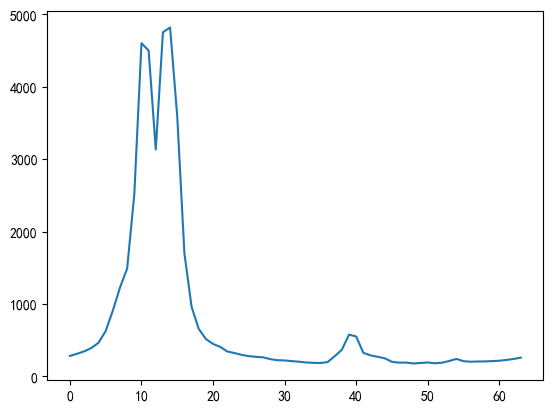

In [2]:
import numpy as np

udp_queue = queue.Queue()
frame_data = []  # 使用列表来暂存数据
frame_data_size = 0

# 生成udp包
udp_list = rtc.generate_udp_packet("K:/dataset/2024_3_12/1/",1)
for udp_packet in udp_list:
    udp_queue.put(udp_packet)

print(udp_queue.qsize())

for _ in range(udp_queue.qsize()):
    seq_num, payload_size, payload = rtc._udp_parser(udp_queue.get())
    payload = np.frombuffer(payload, dtype=np.int16)
    frame_data_size += payload.size
    frame_data.append(payload)  # 将数据暂存在列表中


# 将所有数据连接起来
frame = np.concatenate(frame_data)
print(frame.shape)
print(frame_data_size)
# 重组数据
frame = frame.reshape(numLanes*2, -1,order='F')
frame = frame[[0,1,2,3],:] + 1j*frame[[4,5,6,7],:]

data_radar = np.reshape(frame, (n_RX, n_samples, n_chirps, n_frames), order='F')

print(data_radar.shape)  # (4, 64, 255, 30)

# 特征提取
range_profile, speed_profile, angle_profile = rtc.process_frame(data_radar,clutter_removal='avg')

# 压缩维度
arange_profile = np.squeeze(np.mean(np.abs(range_profile), axis=(0, 2))).T
aspeed_profile = np.squeeze(np.mean(np.abs(speed_profile), axis=(0, 1))).T
aangle_profile = np.squeeze(np.mean(np.abs(angle_profile), axis=(1, 2))).T

print(arange_profile.shape)  # (30, 64)

# 压缩aramge_profile维度
arange_profile = np.squeeze(np.mean(np.abs(arange_profile), axis=(0)))
print(arange_profile.shape)  # (64,)

plt.figure()
plt.plot(arange_profile)
plt.show()


In [23]:
import numpy as np

udp_queue = queue.Queue()
frame_data = []  # 使用列表来暂存数据
frame_data_size = 0

# 生成udp包
udp_list = rtc.generate_udp_packet("K:/dataset/2024_3_12/1/",2)
for udp_packet in udp_list:
    udp_queue.put(udp_packet)

print(udp_queue.qsize())

from ABCnet import RadarGestureNet
from ABCnet import one_hot_to_label

model_path = r'K:\aio_radar\lightning_logs\version_68\checkpoints\epoch=74-step=750.ckpt'
model = RadarGestureNet.load_from_checkpoint(model_path).to("cpu")

while udp_queue.qsize():
    seq_num, payload_size, payload = rtc._udp_parser(udp_queue.get())
    payload = np.frombuffer(payload, dtype=np.int16)
    if frame_data_size + payload.size < rtc.single_frame_size * 30:
        frame_data_size += payload.size
        frame_data.append(payload)
    else:
        # 取出刚好要填满的数据
        temp_len = rtc.single_frame_size*30 - frame_data_size
        temp_data = payload[:temp_len]
        
        payload = payload[temp_len:] 
        
        frame_data.append(temp_data)
        
        # 将数据连接起来
        frame = np.concatenate(frame_data)
        print("frame shape:", frame.shape)
        
        frame_data = []  # 清空列表
        frame_data_size = 0  # 清空数据大小
        
        frame_data.append(payload)  # 将剩下的数据暂存在列表中
        frame_data_size += payload.size

        # 重组数据
        frame = frame.reshape(numLanes*2, -1,order='F')
        frame = frame[[0,1,2,3],:] + 1j*frame[[4,5,6,7],:]

        data_radar = np.reshape(frame, (n_RX, n_samples, n_chirps, n_frames), order='F')

        print(data_radar.shape)  # (4, 64, 255, 30)

        # 特征提取
        range_profile, speed_profile, angle_profile = rtc.process_frame(data_radar,clutter_removal='avg')

        # 压缩维度
        range_profile = np.squeeze(np.mean(np.abs(range_profile), axis=(0, 2))).T
        speed_profile = np.squeeze(np.mean(np.abs(speed_profile), axis=(0, 1))).T
        angle_profile = np.squeeze(np.mean(np.abs(angle_profile), axis=(1, 2))).T
        
        range_profile = torch.tensor(range_profile, dtype=torch.float32)
        speed_profile = torch.tensor(speed_profile, dtype=torch.float32)
        angle_profile = torch.tensor(angle_profile, dtype=torch.float32)
        
        
        # 在第0维增加一个维度(如果是二维的)
        if len(range_profile.shape) == 2:
            range_profile = range_profile.unsqueeze(0)
        if len(speed_profile.shape) == 2:
            speed_profile = speed_profile.unsqueeze(0)
        if len(angle_profile.shape) == 2:
            angle_profile = angle_profile.unsqueeze(0)
        
        out = model(range_profile, speed_profile, angle_profile)
        confidence = out[0][one_hot_to_label(out)].item()
        if confidence > 0.55:
            print(out)
            print("Prediction:", one_hot_to_label(out), "!!!!!!!!!!!!!!!!!!")
        print("confidence:",confidence)


当前i: 0 当前bin_file: K:/dataset/2024_3_12/1\100_Raw_0.bin
当前i: 1 当前bin_file: K:/dataset/2024_3_12/1\10_Raw_0.bin
10761
frame shape: (3916800,)
(4, 64, 255, 30)
tensor([[0.7588, 0.0023, 0.2376, 0.0013]], grad_fn=<SoftmaxBackward0>)
Prediction: tensor([0]) !!!!!!!!!!!!!!!!!!
remaining udp_queue size: 5380
confidence: 0.758843183517456
frame shape: (3916800,)
(4, 64, 255, 30)
tensor([[9.9990e-01, 8.3385e-05, 7.2529e-06, 6.8372e-06]],
       grad_fn=<SoftmaxBackward0>)
Prediction: tensor([0]) !!!!!!!!!!!!!!!!!!
remaining udp_queue size: 0
confidence: 0.9999024868011475
